In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import deque
import random as rand
import math
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [4]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [5]:
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 100

GAMMA = 1.2
batch_size = 128
episode_done = 1000

In [6]:
df = pd.read_excel('./documents/aug_nine_var.xlsx').iloc[:,1:22]

scaler = MinMaxScaler()
X = scaler.fit_transform(df)

In [7]:
def return_latest():
    df = pd.read_excel('./documents/aug_nine_var.xlsx').iloc[:,1::]
    X = df.iloc[:,0:21]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    latest = X[-1].reshape(1, 21)

    return latest

In [8]:
def return_state(action, state):
    if action % 2 == 0:
        var = -0.01
    
    else:
        var = 0.01

    j = int(action / 2)
    
    state[0][j] = state[0][j] + var
    next_state = state

    return next_state

In [9]:
def return_reward(state, y_pred):
    real_state = return_latest()

    dist = np.sqrt(np.sum(np.square(real_state-state)))

    a = tf.cast(tf.math.subtract(y_pred, 42), dtype=tf.float32)
    b = tf.cast(dist, dtype=tf.float32)

    loss = tf.math.add(a, b)
    return tf.math.multiply(loss, 100)

In [15]:
class Dqn_agent:
    def __init__(self):
        self.target = self._create_model()
        self.model = self._create_model()

        self.target.set_weights(self.model.get_weights())

        self.memory = deque(maxlen=10000)
        
    def _create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(128, input_shape=(21, ), activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(42, activation='linear'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse')

        return model

    def forward(self, x):
        x = self.model(x)
        return x
    
    def memorize(self, state, action, reward, next_state):
        self.memory.append((
            state, action,
            tf.cast(reward, tf.float16), next_state
        ))

    def act(self, state, episode):
        eps_threshold = EPS_END + ((EPS_START - EPS_END) * (100 / episode))
        if rand.random() > eps_threshold:
            return tf.convert_to_tensor([np.argmin(self.forward(state))]), eps_threshold
        else:
            return tf.convert_to_tensor([rand.randrange(42)]), eps_threshold

    def learn(self, episode):
        if len(self.memory) < batch_size:
            return

        batch = rand.sample(self.memory, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = tf.convert_to_tensor(states).reshape(batch_size, 21) # (batch_size, 21)
        actions = tf.convert_to_tensor(actions) # (batch_size, )
        rewards = tf.convert_to_tensor(rewards).reshape(batch_size, 1) # (batch_size, )
        next_states = tf.convert_to_tensor(next_states).reshape(batch_size, 21) # (batch_size, 21)

        # print(f"s: {states.shape}, a: {actions.shape}, r: {rewards.shape}, ns: {next_states.shape}")

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target.predict(next_states, verbose=0)

        # print(f"cq: {current_q.shape}, nq: {next_q.shape}")

        for i in range(batch_size):
            if episode == episode_done:
                next_q_value = rewards[i]
            else:
                next_q_value = rewards[i] + GAMMA * np.min(next_q[i])
            
            current_q[i][actions[i]] = next_q_value

        self.model.train_on_batch(states, current_q)
        return self.model.evaluate(states, current_q, batch_size=batch_size, verbose=0)
        

In [16]:
agent = Dqn_agent()
sc_hist = []
st_hist = []
pop_hist = []

for e in range(1, 100):
    state = return_latest()
    steps = 0

    if e % 50 == 0:
        agent.target.set_weights(agent.model.get_weights())
    while True:
        pred_y = dnn_model.predict(state, verbose=0)

        action, eps = agent.act(state, e)

        next_state = return_state(action, state)
        reward = return_reward(state, pred_y)

        agent.memorize(state, action, reward, next_state)
        loss = agent.learn(e)

        state = next_state
        steps = steps + 1

        if steps % 200 == 0:
            print(f"steps: {steps}, reward: {reward[0][0]:.6f}, pop: {int(pred_y)}, loss: {loss:.4f}")

        if steps == episode_done:
            print("=============episode done=============")
            print(f"episode: {e}, reward: {reward}, y_pred: {pred_y}, eps: {eps}")
            print("=======================================")
            sc_hist.append(reward)
            st_hist.append(state)
            pop_hist.append(pred_y)
            break

steps: 200, reward: 233.811707, pop: 44, loss: 930.2734
steps: 400, reward: 282.743866, pop: 44, loss: 1238.3550
steps: 600, reward: 226.083710, pop: 44, loss: 950.9575
steps: 800, reward: 291.021851, pop: 44, loss: 403.0382
steps: 1000, reward: 246.203644, pop: 44, loss: 38.4199
=============episode done=============
episode: 1, reward: [[246.20364]], y_pred: [[44.178135]], eps: 0.9901493354116764
steps: 200, reward: 141.854889, pop: 43, loss: 43.1950
steps: 400, reward: 26.918892, pop: 42, loss: 92.7836
steps: 600, reward: -9.515050, pop: 41, loss: 128.3903
steps: 800, reward: 39.262733, pop: 42, loss: 188.9268
steps: 1000, reward: 17.035723, pop: 41, loss: 178.1862
=============episode done=============
episode: 2, reward: [[17.035723]], y_pred: [[41.84911]], eps: 0.9803966865736877
steps: 200, reward: 240.054031, pop: 44, loss: 139.4677
steps: 400, reward: 285.356689, pop: 44, loss: 102.3647
steps: 600, reward: 272.396637, pop: 44, loss: 91.1058
steps: 800, reward: 365.513458, pop:

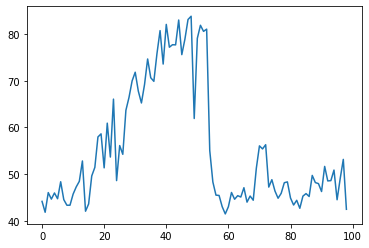

In [17]:
plt.plot(np.array(pop_hist).reshape(len(pop_hist)))
plt.show()

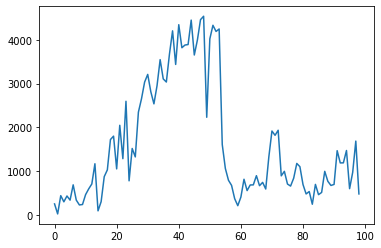

In [18]:
plt.plot(np.array(sc_hist).reshape(len(sc_hist)))
plt.show()

In [19]:
np_st_hist = np.array(st_hist)

In [20]:
np_st_hist.shape

(99, 1, 21)

In [ ]:
result = np.array(st_hist).reshape(99, 21)
X_result = scaler.inverse_transform(result)
pop_result = np.array(pop_hist).reshape(99, 1)

In [ ]:
df = np.append(X_result, pop_result, axis=1)

In [ ]:
pd_df = pd.DataFrame(df)
pd_df.to_excel('./documents/result/dqn.xlsx')